In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Polygon, MultiPoint, Point
from shapely.ops import unary_union, nearest_points
import networkx as nx
import matplotlib.pyplot as plt
import folium
import json
from tqdm import tqdm
from geopy.distance import geodesic
import numpy as np
from shapely.geometry import LineString, MultiLineString

In [2]:
road_data1 = gpd.read_file("/lustrehome/niloofar/niloofar_work/roadnetwork/Apuglia/Apuglia1.geojson")
road_data2 = gpd.read_file("/lustrehome/niloofar/niloofar_work/roadnetwork/Apuglia/Apuglia2.geojson")
road_data = pd.concat([road_data1, road_data2], ignore_index=True)

In [3]:
road_data

,osm_id,osm_type,width,name,surface,tunnel,oneway,highway,layer,smoothness,bridge,geometry
0,1221819115,ways_line,None,None,asphalt,None,no,cycleway,None,None,None,"LINESTRING (16.78882 41.07938, 16.78877 41.079..."
1,1225370037,ways_line,None,None,None,None,None,footway,None,None,None,"LINESTRING (16.78473 41.07850, 16.78472 41.078..."
2,1225371934,ways_line,None,None,None,None,None,service,None,None,None,"LINESTRING (16.78470 41.07718, 16.78472 41.077..."
3,258928002,ways_line,None,Via Federico II,asphalt,None,yes,tertiary,None,None,None,"LINESTRING (16.77920 40.89013, 16.77924 40.889..."
4,432952711,ways_line,None,None,None,None,None,footway,None,None,None,"LINESTRING (16.78104 41.08332, 16.78160 41.083..."
...,...,...,...,...,...,...,...,...,...,...,...,...
363261,189099507,ways_line,None,Strada Comunale esterna Jannone,asphalt,None,None,unclassified,None,None,None,"LINESTRING (16.78807 40.76813, 16.78799 40.768..."
363262,691774891,ways_line,None,None,None,None,None,track,None,None,None,"LINESTRING (16.78325 40.56831, 16.78321 40.568..."
363263,203367964,ways_line,None,None,None,None,None,unclassified,None,None,None,"LINESTRING (16.91638 40.76141, 16.91618 40.761..."
363264,751846649,ways_line,None,Strada Vicinale Casette Vincenzulli,None,None,None,track,None,None,None,"LINESTRING (16.90282 40.72431, 16.90271 40.724..."


In [4]:
def are_points_close(point1, point2, tolerance=1.0):
    return Point(point1).distance(Point(point2)) <= tolerance

In [5]:
gdf = gpd.GeoDataFrame(road_data, geometry='geometry')
bridge_gdf = gdf[gdf['bridge'].notna()] 
bridge_gdf = bridge_gdf.set_crs("EPSG:4326")
bridge_gdf = bridge_gdf[bridge_gdf.geometry.is_valid & ~bridge_gdf.geometry.is_empty]

In [6]:
# Function to extract the start and end points of each LineString geometry
def get_start_end_points(geometry):
    if geometry.geom_type == 'LineString':
        # Extract the first and last coordinates
        start_point = geometry.coords[0]  
        end_point = geometry.coords[-1]   
        return start_point, end_point
    else:
        return None, None
# Apply the function to extract start and end points for each bridge segment
bridge_gdf['start_point'], bridge_gdf['end_point'] = zip(*bridge_gdf['geometry'].apply(get_start_end_points))
print(bridge_gdf[['osm_id', 'start_point', 'end_point']])

            osm_id               start_point                 end_point
78       183411341  (15.1028896, 41.1630426)  (15.1029814, 41.1632846)
94      1036088939  (16.8937588, 41.0878447)  (16.8940228, 41.0879806)
95      1263507576  (16.8937833, 41.0882639)  (16.8938528, 41.0877627)
109     1262630944  (16.2895994, 41.3041063)  (16.2904396, 41.3041557)
111      474216502   (16.066894, 41.2074735)   (16.0667014, 41.207347)
...            ...                       ...                       ...
362987   188248999  (17.3036281, 40.9335776)   (17.303669, 40.9337794)
363012   915517992  (17.2766696, 40.9395794)   (17.2767258, 40.939537)
363018   913189352  (17.2942822, 40.9466458)    (17.29426, 40.9467065)
363072   295641667  (17.2188737, 40.9768091)  (17.2188164, 40.9768313)
363204    78069743  (16.7860791, 40.6559564)   (16.7852155, 40.656154)

[7444 rows x 3 columns]


In [7]:
G = nx.Graph()

def get_start_end_coordinates(geometry):
    if isinstance(geometry, LineString):
        coords = list(geometry.coords)
    elif isinstance(geometry, MultiLineString):
        coords = []
        for line in geometry.geoms:
            coords.extend(list(line.coords))
    else:
        return None, None
    start_point = coords[0]
    end_point = coords[-1]
    return start_point, end_point

# Function to add edges and nodes to the graph
def build_graph(road_data):
    for idx, row in road_data.iterrows():
        # Get geometry
        line_geom = row['geometry']

        # Extract start and end points
        start_point, end_point = get_start_end_coordinates(line_geom)

        if start_point and end_point:
            # Add nodes with coordinates as attributes
            G.add_node(start_point, coord=start_point)
            G.add_node(end_point, coord=end_point)
            
            # Determine if the edge is a bridge
            is_bridge = row['bridge'] is not None
            
            # Add edge with attributes
            weight = row['width'] if row['width'] is not None else 1 
            G.add_edge(start_point, end_point, weight=weight, is_bridge=is_bridge)

valid_gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty]

build_graph(valid_gdf)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 495679
Number of edges: 329649


/tmp/ipykernel_886/2945264264.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


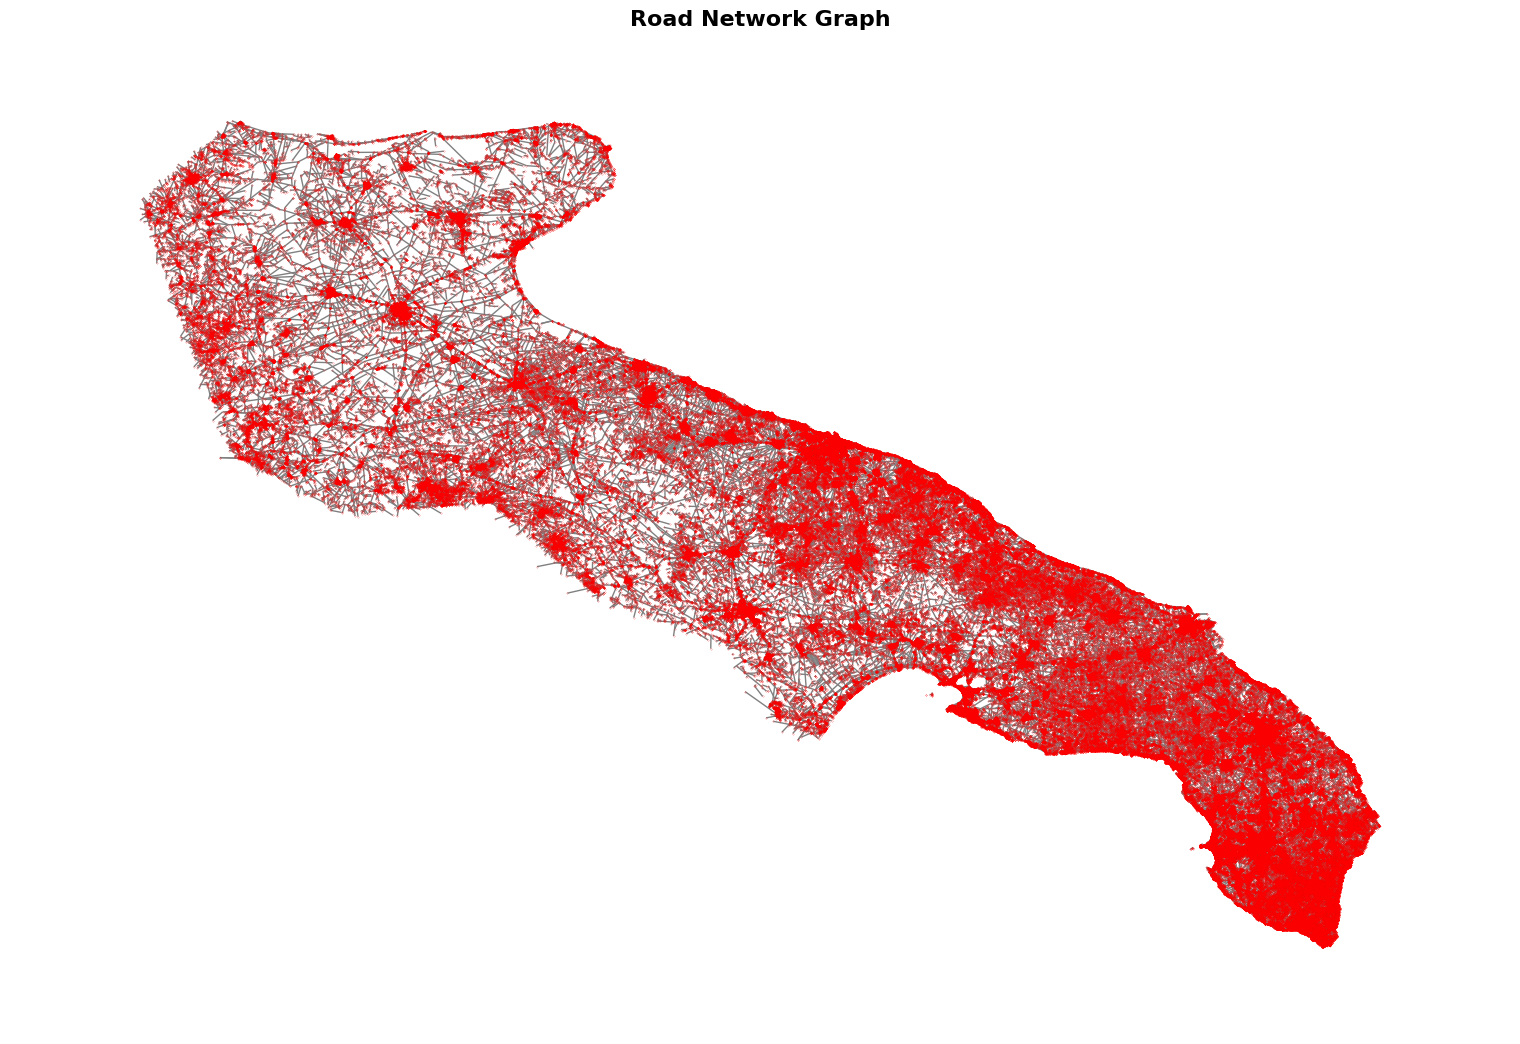

In [35]:
import matplotlib.pyplot as plt

pos = {node: data['coord'] for node, data in G.nodes(data=True) if 'coord' in data}

if not pos:
    print("Error")
else:
    plt.figure(figsize=(15, 10))
    
    nx.draw(
        G,
        pos,
        node_size=0.02,         
        node_color="red",  
        edge_color="gray",  
        with_labels=False,   
        alpha=1            
    )
    
    plt.title("Road Network Graph", fontsize=16, fontweight='bold')
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Extract node positions from the 'coord' attribute
pos = {node: data['coord'] for node, data in G.nodes(data=True) if 'coord' in data}

# Check if `pos` has valid positions
if not pos:
    print("Error: No valid positions found in the graph.")
else:
    plt.figure(figsize=(15, 10))

    # Calculate node sizes based on degree or other metrics (e.g., betweenness centrality)
    node_sizes = [500 * nx.degree(G, node) for node in G.nodes]  # Adjust the multiplier for size scaling
    # Alternatively, you can use betweenness centrality or another measure for node size

    # Calculate edge widths based on the weight of the edge
    edge_widths = [G[u][v].get('weight', 1) for u, v in G.edges]  # Adjust for weights if present
    
    # Visualize the graph with additional tweaks
    nx.draw(
        G,
        pos,
        node_size=node_sizes,    # Adjust node size dynamically based on degree
        node_color="red",        # Static color for nodes
        edge_color=edge_widths,  # Edge color based on weights
        width=edge_widths,       # Edge width based on weight
        with_labels=False,       # Do not display node labels for now
        alpha=0.8,               # Transparency to reduce visual clutter
        cmap=plt.cm.Blues        # Optional color map for edges (if based on weights)
    )
    
    # Add Title and Axis Labels
    plt.title("Road Network Graph", fontsize=16, fontweight='bold')
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    
    # Add a legend (optional)
    plt.legend(
        loc='upper left', 
        labels=["Edges", "Nodes"], 
        fontsize=12
    )
    
    # Tighten layout and show
    plt.tight_layout()
    plt.show()


In [8]:
road_data.columns

Index(['osm_id', 'osm_type', 'width', 'name', 'surface', 'tunnel', 'oneway',
       'highway', 'layer', 'smoothness', 'bridge', 'geometry'],
      dtype='object')

In [9]:
unique_bridge_values = road_data['bridge'].unique()
print(unique_bridge_values)

[None 'yes' 'viaduct' 'boardwalk' 'collapsed' 'aqueduct' 'movable'
 'covered' 'low_water_crossing']


In [10]:
unique_bridge_values = road_data['highway'].unique()
print(unique_bridge_values)

['cycleway' 'footway' 'service' 'tertiary' 'residential' 'tertiary_link'
 'raceway' 'track' 'path' 'secondary' 'unclassified' 'motorway'
 'primary_link' 'trunk' 'primary' 'steps' 'secondary_link' 'pedestrian'
 'construction' 'trunk_link' 'road' 'motorway_link' 'living_street'
 'emergency_bay' 'corridor' 'proposed' 'bridleway' 'platform' 'demolished'
 'street_lamp' 'razed' 'services']


In [14]:
print(type(nodes))  
print(len(nodes))  

<class 'list'>
84652


In [38]:
# Edge start and end coordinates
edge_start = (15.7599266, 41.5732688)
edge_end = (15.7694857, 41.5775481)

# Convert start and end points to Point objects and reproject for accurate calculations
start_geom = gpd.GeoSeries([Point(edge_start)], crs="EPSG:4326").to_crs("EPSG:3395")
end_geom = gpd.GeoSeries([Point(edge_end)], crs="EPSG:4326").to_crs("EPSG:3395")
road_data = road_data.to_crs("EPSG:3395")  # Reproject road data

# Find the nearest road geometries to the start and end points
nearest_start = road_data.iloc[road_data.distance(start_geom[0]).idxmin()]['geometry']
nearest_end = road_data.iloc[road_data.distance(end_geom[0]).idxmin()]['geometry']

# Create a LineString from the centroids of the nearest roads
edge_geometry = LineString([nearest_start.centroid, nearest_end.centroid])

# Highway-specific buffer distances
highway_buffers = {
    'cycleway': 15, 'footway':15, 'service': 15, 'tertiary': 30,
    'residential':15, 'tertiary_link': 15, 'raceway': 15, 'track': 15,
    'path': 15, 'secondary':20, 'unclassified':30, 'motorway': 15,
    'primary_link': 20, 'trunk': 35, 'primary': 20, 'steps': 15,
    'secondary_link': 20, 'pedestrian':15, 'construction': 15,
    'trunk_link': 40, 'road': 15, 'motorway_link': 50, 'living_street': 3,
    'emergency_bay': 15, 'corridor': 15, 'proposed': 15, 'bridleway': 15,
    'platform': 15, 'demolished': 15, 'street_lamp':15, 'razed': 15,
    'services': 15
}


Applying buffer of 30 km around edge.
Visualizing road data, buffer, and filtered data...


/tmp/ipykernel_886/270544542.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Building graph...


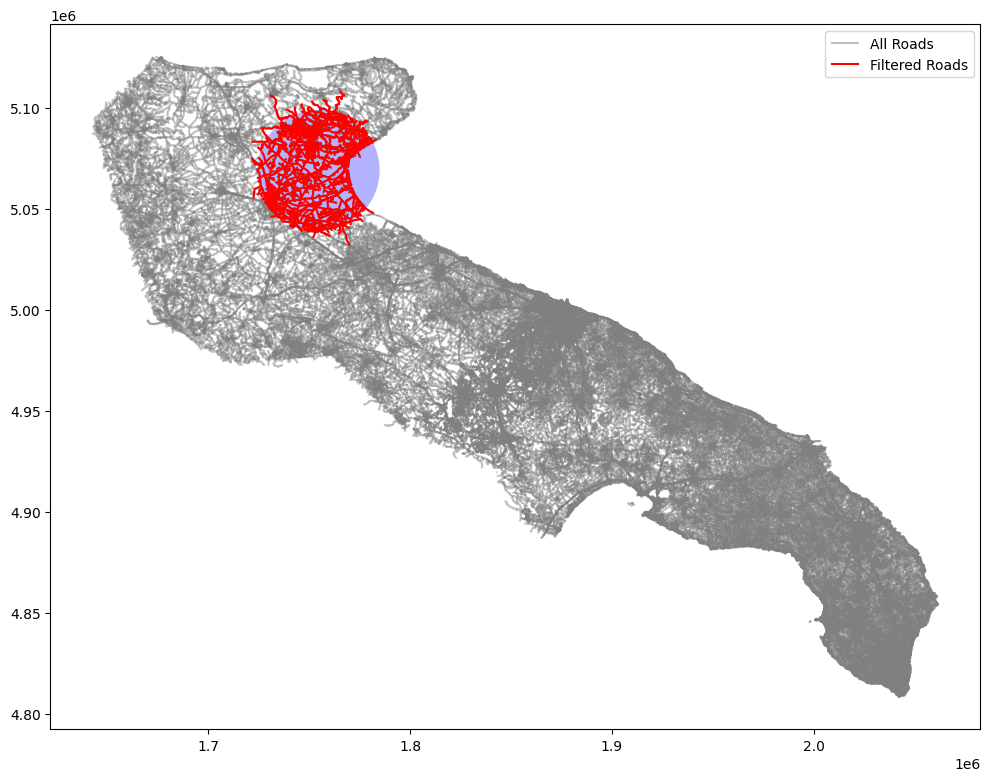

In [39]:
# Determine buffer distance for the edge based on type of the highway that we have in df
edge_highway_type = road_data.loc[road_data['geometry'].intersects(edge_geometry), 'highway'].values
if edge_highway_type.size > 0 and edge_highway_type[0] in highway_buffers:
    buffer_distance = highway_buffers[edge_highway_type[0]]
else:
    buffer_distance = 10  
print(f"Applying buffer of {buffer_distance} km around edge.")

edge_buffer = gpd.GeoSeries([edge_geometry.buffer(buffer_distance * 1000)], crs="EPSG:3395")

# Filter road data within the buffer and rebuild the graph for that specific buffer
filtered_road_data = road_data[road_data['geometry'].intersects(edge_buffer[0])]

# Debugging: Visualize the road network and buffer
print("Visualizing road data, buffer, and filtered data...")
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
road_data.plot(ax=ax, color='gray', alpha=0.5, label='All Roads')
edge_buffer.plot(ax=ax, color='blue', alpha=0.3, label='Buffer')
filtered_road_data.plot(ax=ax, color='red', label='Filtered Roads')
plt.legend()
#plt.show()

# Filter relevant road types
filtered_road_data = filtered_road_data[filtered_road_data['highway'].isin(highway_buffers.keys())]

# Build a network graph using the preferred method
print("Building graph...")
G = nx.Graph()

# Function to extract start and end coordinates
def get_start_end_coordinates(geometry):
    if isinstance(geometry, LineString):
        coords = list(geometry.coords)
    elif isinstance(geometry, MultiLineString):
        coords = []
        for line in geometry.geoms:
            coords.extend(list(line.coords))
    else:
        return None, None
    start_point = coords[0]
    end_point = coords[-1]
    return start_point, end_point

# Function to add edges and nodes to the graph
def build_graph(road_data):
    for idx, row in road_data.iterrows():
        # Get geometry
        line_geom = row['geometry']

        # Extract start and end points
        start_point, end_point = get_start_end_coordinates(line_geom)

        if start_point and end_point:
            # Add nodes with coordinates as attributes
            G.add_node(start_point, coord=start_point)
            G.add_node(end_point, coord=end_point)
            
            # Determine if the edge is a bridge
            is_bridge = row['bridge'] is not None
            
            # Add edge with attributes
            weight = row['width'] if 'width' in row and row['width'] is not None else 1 
            G.add_edge(start_point, end_point, weight=weight, is_bridge=is_bridge)

# Ensure valid geometries in your DataFrame
#valid_gdf = filtered_road_data[filtered_road_data.geometry.is_valid & ~filtered_road_data.geometry.is_empty]

# Build the graph
#build_graph(valid_gdf)

#print(f"Number of nodes: {G.number_of_nodes()}")
#print(f"Number of edges: {G.number_of_edges()}")

# Save the filtered road data and graph for further analysis
#filtered_road_data.to_file("filtered_road_data.geojson", driver="GeoJSON")
#nx.write_gpickle(G, "road_network_graph.gpickle")


In [18]:
print("Node attributes:", list(G.nodes(data=True))[:5])
print("Edge attributes:", list(G.edges(data=True))[:5])

Node attributes: [((1771907.5675753716, 5077320.978904602), {'coord': (1771907.5675753716, 5077320.978904602)}), ((1772366.337460829, 5077687.261039646), {'coord': (1772366.337460829, 5077687.261039646)}), ((1754010.45474181, 5095110.372087267), {'coord': (1754010.45474181, 5095110.372087267)}), ((1753395.7596455985, 5093953.021871103), {'coord': (1753395.7596455985, 5093953.021871103)}), ((1769488.4391931465, 5062213.105269987), {'coord': (1769488.4391931465, 5062213.105269987)})]
Edge attributes: [((1771907.5675753716, 5077320.978904602), (1772366.337460829, 5077687.261039646), {'weight': 1, 'is_bridge': False}), ((1771907.5675753716, 5077320.978904602), (1771978.9790287153, 5077219.86283461), {'weight': 1, 'is_bridge': False}), ((1771907.5675753716, 5077320.978904602), (1771816.9646418148, 5077437.452895162), {'weight': 1, 'is_bridge': False}), ((1771907.5675753716, 5077320.978904602), (1771548.6290092578, 5077041.46199413), {'weight': 1, 'is_bridge': False}), ((1772366.337460829, 5